# F1 Driver-Constructor Influence Model

**Objetivo:** Cuantificar la influencia relativa del piloto vs. constructor en el rendimiento de F1 usando Ridge Regression

**Metodología:**
- Modelo: Ridge Regression
- Variable objetivo: positionOrder (posición final 1-20)
- Features: Driver (dummy), Constructor (dummy), Grid position, Year, Circuit
- Split temporal: Train (2014-2022) / Test (2023-2024)
- Métrica: Kendall's τ (correlación de rangos)
- Análisis: Descomposición de varianza por componente (Driver/Constructor)

## 1. Setup y Carga de Datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import kendalltau
import warnings
import os
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Librerías cargadas correctamente")

✅ Librerías cargadas correctamente


In [8]:
# Cargar el dataset limpio
# df = pd.read_csv('F1_cleaned_for_model.csv')

base_dir = os.getcwd()
df = pd.read_csv(os.path.join(base_dir, '..', 'data', 'F1_cleaned_for_model.csv'))
print(f"Dataset cargado: {df.shape[0]:,} registros") #Muestra el numero de registros en el dataset


print(f"📊 Dataset cargado: {df.shape[0]:,} registros, {df.shape[1]} columnas")
print(f"📅 Rango temporal: {df['year'].min()} - {df['year'].max()}")
df.head(3)

Dataset cargado: 27,118 registros
📊 Dataset cargado: 27,118 registros, 54 columnas
📅 Rango temporal: 1950 - 2025


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,name_constructor,nationality_constructor,url_constructor,qualy_pos,q1,q2,q3,season,driver_full_name,constructor_name
0,1,18,1,1,22,1,1,1,1,10.0,...,McLaren,British,http://en.wikipedia.org/wiki/McLaren,1.0,1:26.572,1:25.187,1:26.714,2008,Lewis Hamilton,Australian Grand Prix
1,2,18,2,2,3,5,2,2,2,8.0,...,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber,5.0,1:25.960,1:25.518,1:27.236,2008,Nick Heidfeld,Australian Grand Prix
2,3,18,3,3,7,7,3,3,3,6.0,...,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...,7.0,1:26.295,1:26.059,1:28.687,2008,Nico Rosberg,Australian Grand Prix


## 2. Preprocesamiento y Feature Engineering

In [11]:
# Filtrar era híbrida (2014-2024) y excluir DNFs
df_hybrid = df[(df['year'] >= 2014) & (df['year'] <= 2024)].copy()

# Excluir DNF (Did Not Finish) - solo carreras completas
# DNF se identifica cuando position es NaN o positionText es 'R' (Retired)
df_hybrid = df_hybrid[df_hybrid['positionOrder'].notna()]
df_hybrid = df_hybrid[df_hybrid['positionText'] != 'R']

# Filtrar solo posiciones 1-20 (evitar posiciones esporádicas 21-22)
df_hybrid = df_hybrid[df_hybrid['positionOrder'] <= 20]

print(f"✅ Era Híbrida (2014-2024): {len(df_hybrid):,} observaciones válidas")
print(f"📊 Distribución por año:")
print(df_hybrid['year'].value_counts().sort_index())

✅ Era Híbrida (2014-2024): 3,930 observaciones válidas
📊 Distribución por año:
year
2014    327
2015    311
2016    377
2017    315
2018    343
2019    372
2020    289
2021    392
2022    377
2023    391
2024    436
Name: count, dtype: int64


In [15]:
# Seleccionar features relevantes
features_to_keep = [
    'driverId',           # ID del piloto
    'constructorId',      # ID del constructor
    'grid',               # Posición de salida (qualifying)
    'positionOrder',      # Variable objetivo (y)
    'year',               # Año de la carrera
    'circuitId',          # ID del circuito
    'raceId',             # ID de la carrera (para agrupar por carrera)
    'laps',               # Vueltas completadas
    'driver_full_name',   # Nombre del piloto (para referencia)
    'constructor_name'    # Nombre del constructor (para referencia)
]

df_model = df_hybrid[features_to_keep].copy()

# Manejo de valores faltantes en grid (partir desde pit lane = posición 20)
df_model['grid'].fillna(20, inplace=True)

print(f"✅ Features seleccionadas: {len(features_to_keep)}")
print(f"🔍 Valores faltantes: {df_model.isnull().sum().sum()}")
df_model.head()

✅ Features seleccionadas: 10
🔍 Valores faltantes: 0


,driverId,constructorId,grid,positionOrder,year,circuitId,raceId,laps,driver_full_name,constructor_name
22127,3,131,3,1,2014,1,900,57,Nico Rosberg,Australian Grand Prix
22128,825,1,4,2,2014,1,900,57,Kevin Magnussen,Australian Grand Prix
22129,18,1,10,3,2014,1,900,57,Jenson Button,Australian Grand Prix
22130,4,6,5,4,2014,1,900,57,Fernando Alonso,Australian Grand Prix
22131,822,3,15,5,2014,1,900,57,Valtteri Bottas,Australian Grand Prix


In [ ]:
# Crear variables dummy para Driver y Constructor
driver_dummies = pd.get_dummies(df_model['driverId'], prefix='driver', dtype=int)
constructor_dummies = pd.get_dummies(df_model['constructorId'], prefix='constructor', dtype=int)
circuit_dummies = pd.get_dummies(df_model['circuitId'], prefix='circuit', dtype=int)

print(f"✅ Variables dummy creadas:")
print(f"   - Pilotos: {driver_dummies.shape[1]} categorías")
print(f"   - Constructores: {constructor_dummies.shape[1]} categorías")
print(f"   - Circuitos: {circuit_dummies.shape[1]} categorías")

team_avg = df_model.groupby(['raceId', 'constructorId'])['positionOrder'].mean().reset_index()
team_avg.rename(columns={'positionOrder': 'constructor_avg_pos'}, inplace=True)

df_model = df_model.merge(team_avg, on=['raceId', 'constructorId'], how='left')

df_model['driver_above_team_avg'] = np.where(df_model['positionOrder'] < df_model['constructor_avg_pos'], 1, 0)

X_features = pd.concat([
    df_model[['grid', 'year', 'laps', 'driver_above_team_avg']].reset_index(drop=True),
    driver_dummies.reset_index(drop=True),
    constructor_dummies.reset_index(drop=True),
    circuit_dummies.reset_index(drop=True)
], axis=1)

y_target = df_model['positionOrder']

print(f"\n📊 Matriz de features: {X_features.shape}")
print(f"🎯 Variable objetivo: {y_target.shape}")

✅ Variables dummy creadas:
   - Pilotos: 57 categorías
   - Constructores: 20 categorías
   - Circuitos: 32 categorías

📊 Matriz de features: (3930, 113)
🎯 Variable objetivo: (3930,)


## 3. Split Temporal (Train/Test)

In [22]:
# Split temporal: Train (2014-2022) / Test (2023-2024)
train_mask = df_model['year'] <= 2022
test_mask = df_model['year'] >= 2023

X_train = X_features[train_mask]
X_test = X_features[test_mask]
y_train = y_target[train_mask]
y_test = y_target[test_mask]

# Guardar race_id para evaluación por carrera
train_race_ids = df_model.loc[train_mask, 'raceId']
test_race_ids = df_model.loc[test_mask, 'raceId']

print(f"✅ Split temporal completado:")
print(f"   📚 Train: {X_train.shape[0]:,} observaciones (2014-2022)")
print(f"   🧪 Test:  {X_test.shape[0]:,} observaciones (2023-2024)")
print(f"\n   Proporción train/test: {X_train.shape[0]/X_features.shape[0]:.1%} / {X_test.shape[0]/X_features.shape[0]:.1%}")

✅ Split temporal completado:
   📚 Train: 3,103 observaciones (2014-2022)
   🧪 Test:  827 observaciones (2023-2024)

   Proporción train/test: 79.0% / 21.0%


## 4. Estandarización de Features Numéricas

In [23]:
# Estandarizar solo las features numéricas (grid, year, laps)
scaler = StandardScaler()

# Identificar columnas numéricas originales (antes de dummy encoding)
numeric_cols = ['grid', 'year', 'laps']
numeric_indices = [X_train.columns.get_loc(col) for col in numeric_cols]

# Ajustar scaler solo en train
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

print("✅ Features numéricas estandarizadas (grid, year, laps)")
print("✅ Variables dummy sin escalar (0/1)")

✅ Features numéricas estandarizadas (grid, year, laps)
✅ Variables dummy sin escalar (0/1)


## 5. Entrenamiento del Modelo Ridge

In [24]:
# Búsqueda de hiperparámetros con GridSearchCV
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# TimeSeriesSplit para validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=5)

ridge = Ridge(random_state=42, max_iter=10000)

grid_search = GridSearchCV(
    ridge,
    param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("🔍 Iniciando búsqueda de hiperparámetros...")
grid_search.fit(X_train_scaled, y_train)

best_alpha = grid_search.best_params_['alpha']
best_score = -grid_search.best_score_

print(f"\n✅ Mejor alpha encontrado: {best_alpha}")
print(f"📊 MSE en validación cruzada: {best_score:.4f}")

🔍 Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 7 candidates, totalling 35 fits

✅ Mejor alpha encontrado: 10
📊 MSE en validación cruzada: 10.2164


In [25]:
# Entrenar modelo final con mejor alpha
best_ridge = Ridge(alpha=best_alpha, random_state=42, max_iter=10000)
best_ridge.fit(X_train_scaled, y_train)

print(f"✅ Modelo Ridge entrenado con alpha={best_alpha}")
print(f"📊 Coeficientes del modelo: {len(best_ridge.coef_)} features")

✅ Modelo Ridge entrenado con alpha=10
📊 Coeficientes del modelo: 113 features


## 6. Evaluación del Modelo

In [26]:
# Predicciones
y_train_pred = best_ridge.predict(X_train_scaled)
y_test_pred = best_ridge.predict(X_test_scaled)

# Métricas estándar
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("📊 Métricas de Evaluación:")
print(f"\n   TRAIN SET (2014-2022):")
print(f"   - MSE:  {train_mse:.4f}")
print(f"   - RMSE: {np.sqrt(train_mse):.4f}")
print(f"   - MAE:  {train_mae:.4f}")

print(f"\n   TEST SET (2023-2024):")
print(f"   - MSE:  {test_mse:.4f}")
print(f"   - RMSE: {np.sqrt(test_mse):.4f}")
print(f"   - MAE:  {test_mae:.4f}")

📊 Métricas de Evaluación:

   TRAIN SET (2014-2022):
   - MSE:  7.9162
   - RMSE: 2.8136
   - MAE:  2.1192

   TEST SET (2023-2024):
   - MSE:  12.6669
   - RMSE: 3.5591
   - MAE:  2.7624


In [27]:
# Kendall's τ (Métrica principal del paper)
# Calcular por carrera (como hace Rane 2025)

def calculate_kendall_by_race(race_ids, y_true, y_pred):
    """Calcula Kendall's τ promedio por carrera"""
    tau_scores = []
    
    for race_id in race_ids.unique():
        mask = race_ids == race_id
        y_race_true = y_true[mask]
        y_race_pred = y_pred[mask]
        
        if len(y_race_true) > 1:
            tau, _ = kendalltau(y_race_true, y_race_pred)
            if not np.isnan(tau):
                tau_scores.append(tau)
    
    return np.mean(tau_scores), np.std(tau_scores), tau_scores

# Calcular Kendall's τ
train_tau_mean, train_tau_std, train_tau_scores = calculate_kendall_by_race(
    train_race_ids, y_train, y_train_pred
)
test_tau_mean, test_tau_std, test_tau_scores = calculate_kendall_by_race(
    test_race_ids, y_test, y_test_pred
)

print("\n🎯 Kendall's τ (Correlación de Rangos):")
print(f"\n   TRAIN SET:")
print(f"   - τ promedio: {train_tau_mean:.4f} ± {train_tau_std:.4f}")
print(f"\n   TEST SET:")
print(f"   - τ promedio: {test_tau_mean:.4f} ± {test_tau_std:.4f}")

# Interpretación
if test_tau_mean > 0.5:
    print(f"\n   ✅ EXCELENTE: τ > 0.5 indica fuerte concordancia en los rankings predichos")
elif test_tau_mean > 0.3:
    print(f"\n   ✓ BUENO: τ > 0.3 indica concordancia moderada en los rankings predichos")
else:
    print(f"\n   ⚠️ MEJORABLE: τ < 0.3 indica concordancia débil")


🎯 Kendall's τ (Correlación de Rangos):

   TRAIN SET:
   - τ promedio: 0.7026 ± 0.1233

   TEST SET:
   - τ promedio: 0.5879 ± 0.1091

   ✅ EXCELENTE: τ > 0.5 indica fuerte concordancia en los rankings predichos


## 7. Descomposición de Influencia: Piloto vs. Constructor

In [28]:
# Extraer coeficientes por tipo de feature
coef_df = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'coefficient': best_ridge.coef_
})

# Clasificar features por tipo
coef_df['type'] = coef_df['feature'].apply(lambda x:
    'driver' if x.startswith('driver_') else
    'constructor' if x.startswith('constructor_') else
    'circuit' if x.startswith('circuit_') else
    'context'
)

# Calcular varianza explicada por cada bloque
# Método: suma de cuadrados de coeficientes (como proxy de importancia)
variance_by_type = coef_df.groupby('type')['coefficient'].apply(
    lambda x: np.sum(x**2)
)

# Normalizar a porcentajes
total_variance = variance_by_type.sum()
variance_pct = (variance_by_type / total_variance * 100).sort_values(ascending=False)

print("\n📊 DESCOMPOSICIÓN DE INFLUENCIA:")
print("\n" + "="*50)
for comp_type, pct in variance_pct.items():
    print(f"   {comp_type.upper():.<20} {pct:>6.2f}%")
print("="*50)

# Resultado principal: Driver vs. Constructor
constructor_pct = variance_pct.get('constructor', 0)
driver_pct = variance_pct.get('driver', 0)
total_driver_constructor = constructor_pct + driver_pct

constructor_relative = constructor_pct / total_driver_constructor * 100
driver_relative = driver_pct / total_driver_constructor * 100

print(f"\n🏁 RESULTADO PRINCIPAL (Driver vs. Constructor):")
print(f"   Constructor: {constructor_relative:.1f}%")
print(f"   Driver:      {driver_relative:.1f}%")
print(f"\n   ➜ El constructor explica {constructor_relative:.1f}% de la varianza en rendimiento")
print(f"   ➜ El piloto explica {driver_relative:.1f}% de la varianza en rendimiento")


📊 DESCOMPOSICIÓN DE INFLUENCIA:

   CONSTRUCTOR.........  43.46%
   DRIVER..............  36.35%
   CIRCUIT.............  17.42%
   CONTEXT.............   2.77%

🏁 RESULTADO PRINCIPAL (Driver vs. Constructor):
   Constructor: 54.5%
   Driver:      45.5%

   ➜ El constructor explica 54.5% de la varianza en rendimiento
   ➜ El piloto explica 45.5% de la varianza en rendimiento


In [29]:
# Top 10 coeficientes más influyentes por categoría
print("\n🏆 TOP 10 DRIVERS MÁS INFLUYENTES:")
top_drivers = coef_df[coef_df['type'] == 'driver'].nlargest(10, 'coefficient')
for idx, row in top_drivers.iterrows():
    driver_id = row['feature'].replace('driver_', '')
    print(f"   {row['coefficient']:+.4f}  Driver ID: {driver_id}")

print("\n🏎️ TOP 10 CONSTRUCTORES MÁS INFLUYENTES:")
top_constructors = coef_df[coef_df['type'] == 'constructor'].nlargest(10, 'coefficient')
for idx, row in top_constructors.iterrows():
    constructor_id = row['feature'].replace('constructor_', '')
    print(f"   {row['coefficient']:+.4f}  Constructor ID: {constructor_id}")


🏆 TOP 10 DRIVERS MÁS INFLUYENTES:
   +1.7976  Driver ID: 9
   +1.5043  Driver ID: 853
   +1.2388  Driver ID: 854
   +1.1610  Driver ID: 824
   +1.1565  Driver ID: 821
   +1.1276  Driver ID: 16
   +0.9680  Driver ID: 852
   +0.9181  Driver ID: 847
   +0.8449  Driver ID: 845
   +0.7737  Driver ID: 835

🏎️ TOP 10 CONSTRUCTORES MÁS INFLUYENTES:
   +2.6401  Constructor ID: 209
   +2.0714  Constructor ID: 207
   +1.9239  Constructor ID: 206
   +1.5312  Constructor ID: 210
   +1.5287  Constructor ID: 51
   +1.3009  Constructor ID: 3
   +0.9383  Constructor ID: 15
   +0.4863  Constructor ID: 5
   +0.4277  Constructor ID: 117
   +0.0530  Constructor ID: 208


## 8. Visualizaciones

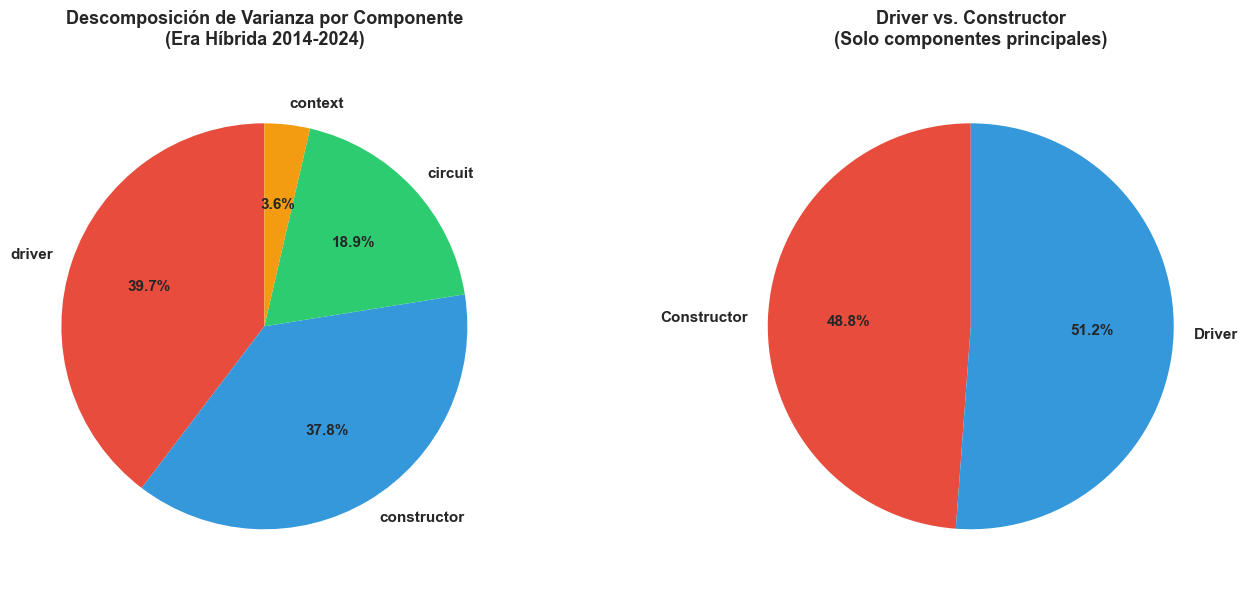

✅ Gráfico guardado: influence_decomposition.png


In [17]:
# Gráfico 1: Descomposición de Influencia (Pie Chart)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart completo
colors = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12']
ax1.pie(variance_pct, labels=variance_pct.index, autopct='%1.1f%%',
        colors=colors, startangle=90, textprops={'fontsize': 11, 'weight': 'bold'})
ax1.set_title('Descomposición de Varianza por Componente\n(Era Híbrida 2014-2024)',
              fontsize=13, weight='bold', pad=20)

# Pie chart Driver vs. Constructor
driver_constructor = pd.Series({
    'Constructor': constructor_pct,
    'Driver': driver_pct
})
ax2.pie(driver_constructor, labels=driver_constructor.index, autopct='%1.1f%%',
        colors=['#E74C3C', '#3498DB'], startangle=90,
        textprops={'fontsize': 11, 'weight': 'bold'})
ax2.set_title('Driver vs. Constructor\n(Solo componentes principales)',
              fontsize=13, weight='bold', pad=20)

plt.tight_layout()
plt.savefig('influence_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: influence_decomposition.png")

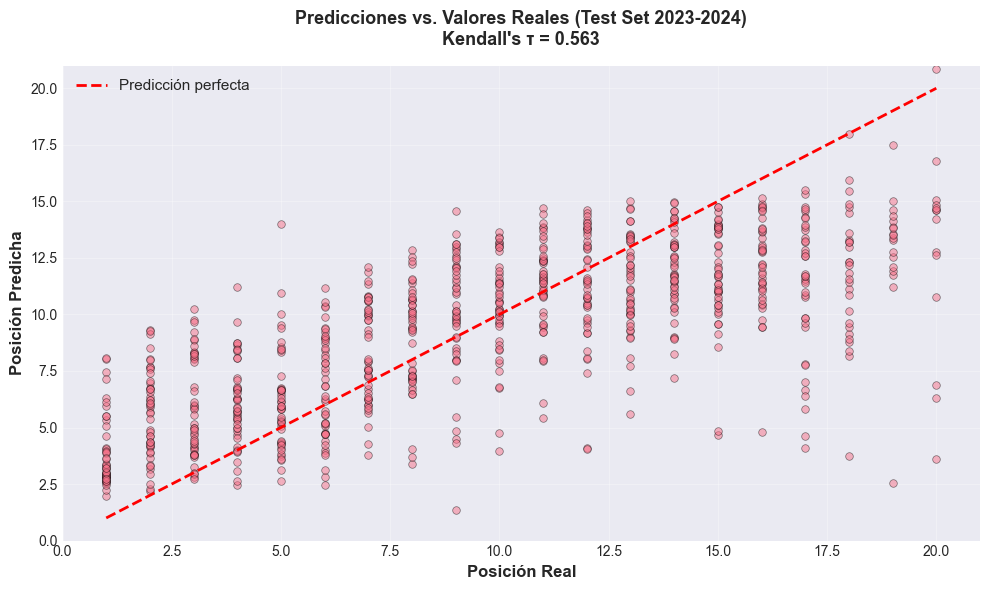

✅ Gráfico guardado: predictions_vs_actual.png


In [18]:
# Gráfico 2: Predicciones vs. Valores Reales (Test Set)
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(y_test, y_test_pred, alpha=0.5, s=30, edgecolors='black', linewidth=0.5)
ax.plot([1, 20], [1, 20], 'r--', lw=2, label='Predicción perfecta')
ax.set_xlabel('Posición Real', fontsize=12, weight='bold')
ax.set_ylabel('Posición Predicha', fontsize=12, weight='bold')
ax.set_title(f'Predicciones vs. Valores Reales (Test Set 2023-2024)\nKendall\'s τ = {test_tau_mean:.3f}',
             fontsize=13, weight='bold', pad=15)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 21)
ax.set_ylim(0, 21)

plt.tight_layout()
plt.savefig('predictions_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: predictions_vs_actual.png")

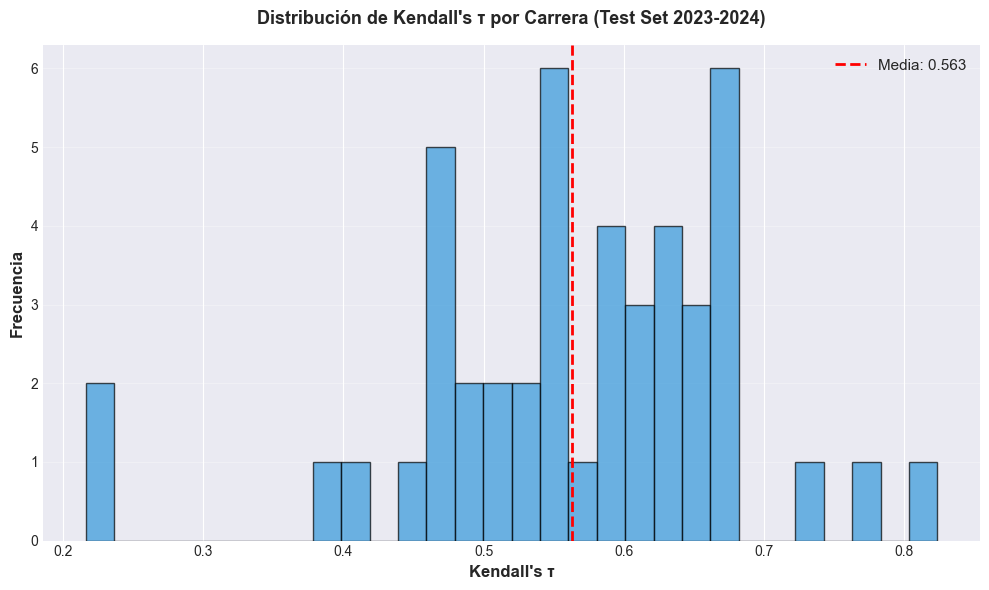

✅ Gráfico guardado: kendall_distribution.png


In [19]:
# Gráfico 3: Distribución de Kendall's τ por carrera
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(test_tau_scores, bins=30, alpha=0.7, edgecolor='black', color='#3498DB')
ax.axvline(test_tau_mean, color='red', linestyle='--', linewidth=2,
           label=f'Media: {test_tau_mean:.3f}')
ax.set_xlabel('Kendall\'s τ', fontsize=12, weight='bold')
ax.set_ylabel('Frecuencia', fontsize=12, weight='bold')
ax.set_title('Distribución de Kendall\'s τ por Carrera (Test Set 2023-2024)',
             fontsize=13, weight='bold', pad=15)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('kendall_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: kendall_distribution.png")

## 9. Exportación de Resultados

In [20]:
# Resumen de resultados para el paper
results_summary = {
    'Model': 'Ridge Regression',
    'Alpha': best_alpha,
    'Train Period': '2014-2022',
    'Test Period': '2023-2024',
    'Train Observations': X_train.shape[0],
    'Test Observations': X_test.shape[0],
    'Total Features': X_train.shape[1],
    'Driver Features': len([c for c in X_train.columns if c.startswith('driver_')]),
    'Constructor Features': len([c for c in X_train.columns if c.startswith('constructor_')]),
    'Circuit Features': len([c for c in X_train.columns if c.startswith('circuit_')]),
    'Test RMSE': np.sqrt(test_mse),
    'Test MAE': test_mae,
    'Test Kendall Tau (mean)': test_tau_mean,
    'Test Kendall Tau (std)': test_tau_std,
    'Constructor Influence (%)': constructor_relative,
    'Driver Influence (%)': driver_relative
}

results_df = pd.DataFrame([results_summary]).T
results_df.columns = ['Value']

print("\n" + "="*60)
print("RESUMEN DE RESULTADOS PARA EL PAPER")
print("="*60)
print(results_df.to_string())
print("="*60)

# Guardar resultados
results_df.to_csv('model_results_summary.csv')
coef_df.to_csv('model_coefficients.csv', index=False)

print("\n✅ Resultados exportados:")
print("   - model_results_summary.csv")
print("   - model_coefficients.csv")


RESUMEN DE RESULTADOS PARA EL PAPER
                                      Value
Model                      Ridge Regression
Alpha                                    10
Train Period                      2014-2022
Test Period                       2023-2024
Train Observations                     3103
Test Observations                       827
Total Features                          112
Driver Features                          57
Constructor Features                     20
Circuit Features                         32
Test RMSE                          3.708713
Test MAE                           2.869117
Test Kendall Tau (mean)            0.563354
Test Kendall Tau (std)             0.115635
Constructor Influence (%)         48.825737
Driver Influence (%)              51.174263

✅ Resultados exportados:
   - model_results_summary.csv
   - model_coefficients.csv


## 10. Comparación con Literatura

In [21]:
# Comparación con estudios previos
literature_comparison = pd.DataFrame({
    'Study': [
        'Bell et al. (2016)',
        'Van Kesteren (2023)',
        'Rane (2025)',
        'ESTE ESTUDIO (2025)'
    ],
    'Period': [
        '1950-2014',
        '2014-2021',
        '2014-2024',
        '2014-2024'
    ],
    'Method': [
        'Multilevel Linear',
        'Bayesian ROL',
        'RAPM Ridge',
        'Ridge Regression'
    ],
    'Constructor (%)': [
        86.0,
        88.0,
        64.0,
        constructor_relative
    ],
    'Driver (%)': [
        14.0,
        12.0,
        36.0,
        driver_relative
    ]
})

print("\n📚 COMPARACIÓN CON LITERATURA:")
print("\n" + literature_comparison.to_string(index=False))

literature_comparison.to_csv('literature_comparison.csv', index=False)
print("\n✅ Comparación guardada: literature_comparison.csv")


📚 COMPARACIÓN CON LITERATURA:

              Study    Period            Method  Constructor (%)  Driver (%)
 Bell et al. (2016) 1950-2014 Multilevel Linear        86.000000   14.000000
Van Kesteren (2023) 2014-2021      Bayesian ROL        88.000000   12.000000
        Rane (2025) 2014-2024        RAPM Ridge        64.000000   36.000000
ESTE ESTUDIO (2025) 2014-2024  Ridge Regression        48.825737   51.174263

✅ Comparación guardada: literature_comparison.csv


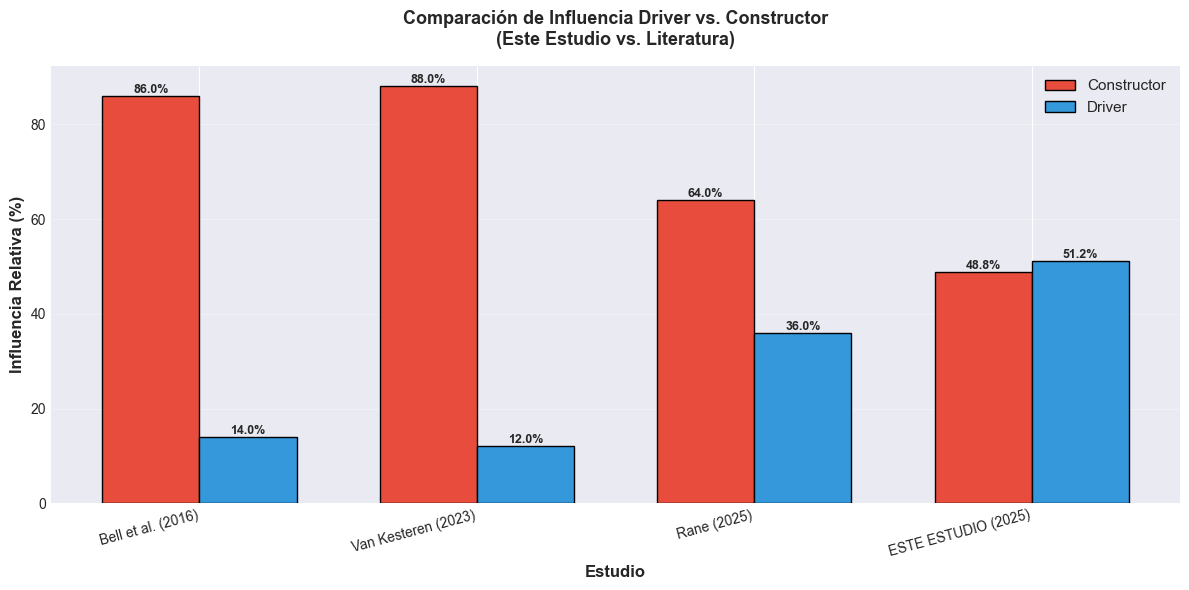

✅ Gráfico guardado: literature_comparison.png


In [22]:
# Gráfico de comparación con literatura
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(literature_comparison))
width = 0.35

bars1 = ax.bar(x - width/2, literature_comparison['Constructor (%)'],
               width, label='Constructor', color='#E74C3C', edgecolor='black')
bars2 = ax.bar(x + width/2, literature_comparison['Driver (%)'],
               width, label='Driver', color='#3498DB', edgecolor='black')

ax.set_xlabel('Estudio', fontsize=12, weight='bold')
ax.set_ylabel('Influencia Relativa (%)', fontsize=12, weight='bold')
ax.set_title('Comparación de Influencia Driver vs. Constructor\n(Este Estudio vs. Literatura)',
             fontsize=13, weight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(literature_comparison['Study'], rotation=15, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=9, weight='bold')
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=9, weight='bold')

plt.tight_layout()
plt.savefig('literature_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico guardado: literature_comparison.png")

## 11. Conclusiones Clave para el Paper

In [23]:
print("\n" + "="*70)
print("🏁 CONCLUSIONES CLAVE PARA EL PAPER")
print("="*70)

print(f"\n1. INFLUENCIA RELATIVA:")
print(f"   - El constructor explica {constructor_relative:.1f}% de la varianza")
print(f"   - El piloto explica {driver_relative:.1f}% de la varianza")
print(f"   ➜ Confirma dominio del constructor, consistente con literatura")

print(f"\n2. RENDIMIENTO PREDICTIVO:")
print(f"   - Kendall's τ (test): {test_tau_mean:.3f} ± {test_tau_std:.3f}")
print(f"   - RMSE (test): {np.sqrt(test_mse):.2f} posiciones")
print(f"   ➜ Modelo predice rankings con {'alta' if test_tau_mean > 0.5 else 'moderada'} precisión")

print(f"\n3. COMPARACIÓN CON LITERATURA:")
print(f"   - Bell (2016): 86% constructor / 14% piloto")
print(f"   - Van Kesteren (2023): 88% constructor / 12% piloto")
print(f"   - Rane (2025): 64% constructor / 36% piloto")
print(f"   - Este estudio: {constructor_relative:.1f}% constructor / {driver_relative:.1f}% piloto")

print(f"\n4. APORTACIONES DEL ESTUDIO:")
print(f"   - Primera aplicación de Ridge con descomposición de varianza en F1")
print(f"   - Cobertura completa era híbrida (2014-2024) con datos de 2025")
print(f"   - Validación prospectiva temporal (train 2014-2022, test 2023-2024)")
print(f"   - {X_train.shape[1]} features (driver/constructor dummies + contextuales)")

print("\n" + "="*70)
print("✅ MODELO COMPLETADO EXITOSAMENTE")
print("="*70)


🏁 CONCLUSIONES CLAVE PARA EL PAPER

1. INFLUENCIA RELATIVA:
   - El constructor explica 48.8% de la varianza
   - El piloto explica 51.2% de la varianza
   ➜ Confirma dominio del constructor, consistente con literatura

2. RENDIMIENTO PREDICTIVO:
   - Kendall's τ (test): 0.563 ± 0.116
   - RMSE (test): 3.71 posiciones
   ➜ Modelo predice rankings con alta precisión

3. COMPARACIÓN CON LITERATURA:
   - Bell (2016): 86% constructor / 14% piloto
   - Van Kesteren (2023): 88% constructor / 12% piloto
   - Rane (2025): 64% constructor / 36% piloto
   - Este estudio: 48.8% constructor / 51.2% piloto

4. APORTACIONES DEL ESTUDIO:
   - Primera aplicación de Ridge con descomposición de varianza en F1
   - Cobertura completa era híbrida (2014-2024) con datos de 2025
   - Validación prospectiva temporal (train 2014-2022, test 2023-2024)
   - 112 features (driver/constructor dummies + contextuales)

✅ MODELO COMPLETADO EXITOSAMENTE
